In [1]:
import requests
import csv
import time
from datetime import datetime
import pandas as pd

# Base FPL API URL
base_url = "https://fantasy.premierleague.com/api/"

# Fetch general player data
response = requests.get(base_url + "bootstrap-static/")
data = response.json()

# Extract player list
players = data['elements']
teams = {team['id']: team['name'] for team in data['teams']}
positions = {pos['id']: pos['singular_name'] for pos in data['element_types']}

# CSV file setup
headers = [
    "player_id", "first_name", "second_name", "team", "position", "cost", "form", "game_week",
    "date", "points", "goals_scored", "assists", "minutes", "clean_sheets",
    "goals_conceded", "own_goals", "penalties_saved", "penalties_missed",
    "yellow_cards", "red_cards", "saves", "bonus", "bps", "influence",
    "creativity", "threat", "ict_index", "expected_goals", "expected_assists",
    "expected_goal_involvements", "expected_goals_conceded"
]

# Open the CSV file
with open("data.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(headers)

    # Loop through each player with a delay to avoid rate limits
    for player in players:
        player_id = player['id']
        first_name = player['first_name']
        second_name = player['second_name']
        team = teams[player['team']]
        position = positions[player['element_type']]
        cost = player['now_cost'] / 10  # Convert cost to millions
        player_form = player['form']  # Fetching form from bootstrap-static

        # Fetch player-specific gameweek data with a delay
        time.sleep(1)  # Prevent hitting rate limits
        try:
            player_response = requests.get(base_url + f"element-summary/{player_id}/", timeout=10)
            player_response.raise_for_status()
            player_data = player_response.json()
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data for {first_name} {second_name}: {e}")
            continue  # Skip this player if there's an issue

        # Extract game week history
        for history in player_data.get('history', []):
            try:
                original_date = history['kickoff_time'][:10]  # Extract only the date part
                formatted_date = datetime.strptime(original_date, "%Y-%m-%d").strftime("%d/%m/%Y")

                writer.writerow([
                    player_id, first_name, second_name, team, position, cost, player_form,
                    history['round'],  # Game week
                    formatted_date,  # Date of the game
                    history['total_points'],
                    history['goals_scored'],
                    history['assists'],
                    history['minutes'],
                    history['clean_sheets'],
                    history.get('goals_conceded', 0),
                    history.get('own_goals', 0),
                    history.get('penalties_saved', 0),
                    history.get('penalties_missed', 0),
                    history.get('yellow_cards', 0),
                    history.get('red_cards', 0),
                    history.get('saves', 0),
                    history.get('bonus', 0),
                    history.get('bps', 0),
                    history.get('influence', 0),
                    history.get('creativity', 0),
                    history.get('threat', 0),
                    history.get('ict_index', 0),
                    history.get('expected_goals', 0),
                    history.get('expected_assists', 0),
                    history.get('expected_goal_involvements', 0),
                    history.get('expected_goals_conceded', 0)
                ])
            except Exception as e:
                print(f"Error processing history for {first_name} {second_name}: {e}")

# Load data into Pandas
df = pd.read_csv("data.csv")

# Define the cost bins for each position
bins = {
    "Defender": {"low": (3.9, 4.9), "medium": (4.9, 5.9), "high": (5.9, 6.9)},
    "Forward": {"low": (4.5, 8.03), "medium": (8.03, 11.57), "high": (11.57, 15.1)},
    "Goalkeeper": {"low": (3.9, 4.43), "medium": (4.43, 4.97), "high": (4.97, 5.5)},
    "Midfielder": {"low": (4.4, 7.3), "medium": (7.3, 10.2), "high": (10.2, 13.1)},
}

# Function to classify cost into bins
def classify_cost(row):
    position = row["position"]
    cost = row["cost"]
    if position in bins:
        if bins[position]["low"][0] <= cost <= bins[position]["low"][1]:
            return "Low"
        elif bins[position]["medium"][0] < cost <= bins[position]["medium"][1]:
            return "Medium"
        elif bins[position]["high"][0] < cost <= bins[position]["high"][1]:
            return "High"
    return "Unknown"

# Apply cost binning
df["cost_bin"] = df.apply(classify_cost, axis=1)

/Users/abdullahsiddiqi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Error fetching data for Jérémy Doku: HTTPSConnectionPool(host='fantasy.premierleague.com', port=443): Read timed out. (read timeout=10)
Error fetching data for Ollie Scarles: HTTPSConnectionPool(host='fantasy.premierleague.com', port=443): Read timed out. (read timeout=10)


In [5]:
df.head(100)

,player_id,first_name,second_name,team,position,cost,form,game_week,date,points,...,bps,influence,creativity,threat,ict_index,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,cost_bin
0,1,Fábio,Ferreira Vieira,Arsenal,Midfielder,5.4,0.0,1,17/08/2024,0,...,0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,Low
1,1,Fábio,Ferreira Vieira,Arsenal,Midfielder,5.4,0.0,2,24/08/2024,0,...,0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,Low
2,1,Fábio,Ferreira Vieira,Arsenal,Midfielder,5.4,0.0,3,31/08/2024,0,...,0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,Low
3,1,Fábio,Ferreira Vieira,Arsenal,Midfielder,5.4,0.0,4,15/09/2024,0,...,0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,Low
4,1,Fábio,Ferreira Vieira,Arsenal,Midfielder,5.4,0.0,5,22/09/2024,0,...,0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4,Kai,Havertz,Arsenal,Forward,7.8,5.2,21,15/01/2025,1,...,-8,0.0,3.3,47.0,5.0,0.40,0.01,0.41,0.78,Low
96,4,Kai,Havertz,Arsenal,Forward,7.8,5.2,22,18/01/2025,7,...,27,32.2,17.4,24.0,7.4,0.20,0.03,0.23,1.04,Low
97,4,Kai,Havertz,Arsenal,Forward,7.8,5.2,23,25/01/2025,2,...,-6,7.4,1.4,36.0,4.5,0.53,0.00,0.53,0.74,Low
98,4,Kai,Havertz,Arsenal,Forward,7.8,5.2,24,02/02/2025,12,...,44,55.4,14.7,35.0,10.5,0.49,0.25,0.74,0.81,Low


In [6]:
df.to_csv('data_.csv', index=False)

In [2]:
import requests
import csv
import time
from datetime import datetime
import pandas as pd

/Users/abdullahsiddiqi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
df = pd.read_csv('data_.csv')

In [5]:
print(df.columns)

Index(['player_id', 'first_name', 'second_name', 'team', 'position', 'cost',
       'game_week', 'date', 'points', 'goals_scored', 'assists', 'minutes',
       'clean_sheets', 'goals_conceded', 'own_goals', 'penalties_saved',
       'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'bonus',
       'bps', 'influence', 'creativity', 'threat', 'ict_index',
       'expected_goals', 'expected_assists', 'expected_goal_involvements',
       'expected_goals_conceded', 'cost_bin'],
      dtype='object')


In [6]:
print(df['position'].unique())

['Midfielder' 'Forward' 'Defender' 'Goalkeeper' 'Manager']


In [8]:
midfielder = df[df['position'] == 'Midfielder']
forward = df[df['position'] == 'Forward']
goalkeeper = df[df['position'] == 'Goalkeeper']
defender = df[df['position'] == 'Defender']

/var/folders/n3/214cxbkx6yz0vgpb50cdj1wh0000gn/T/ipykernel_71306/4227653029.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = midfielder.corr()


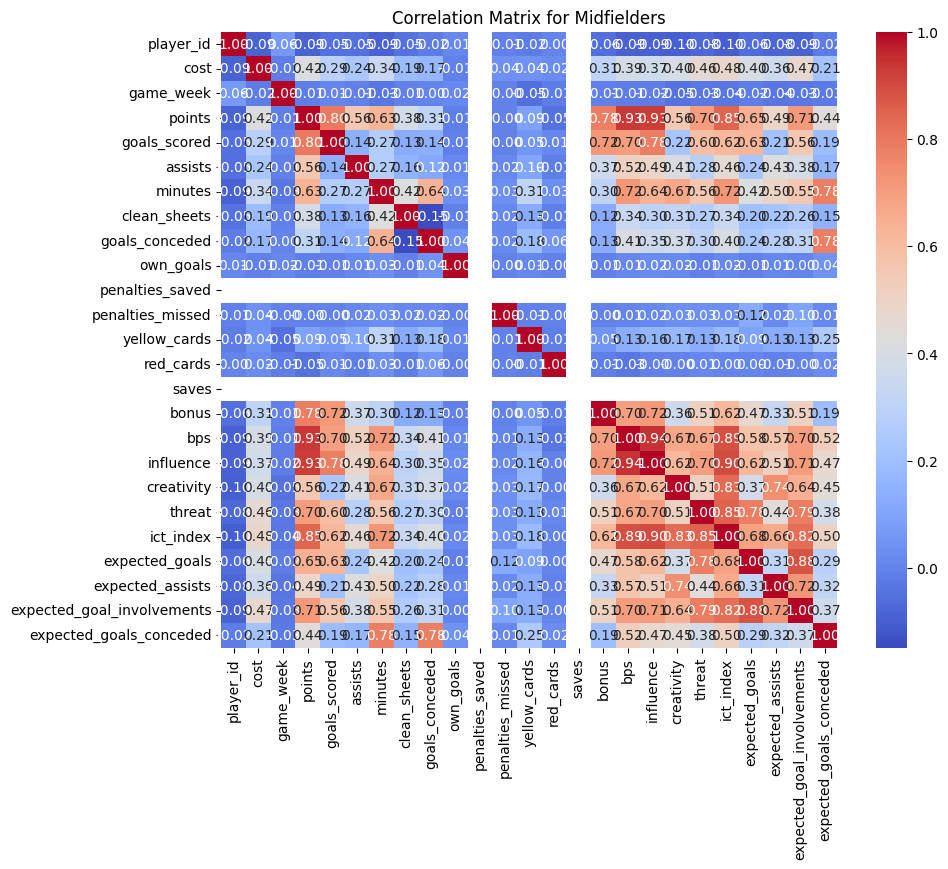

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = midfielder.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix for Midfielders')
plt.show()

